<a href="https://www.bigdatauniversity.com"><img src="https://ibm.box.com/shared/static/cw2c7r3o20w9zn8gkecaeyjhgw3xdgbj.png" width="400" align="center"></a>

<h1 align="center"><font size="5">Classification with Python</font></h1>

In this notebook we try to practice all the classification algorithms that we learned in this course.

We load a dataset using Pandas library, and apply the following algorithms, and find the best one for this specific dataset by accuracy evaluation methods.

Lets first load required libraries:

In [2]:
import itertools
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import NullFormatter
import pandas as pd
import numpy as np
import matplotlib.ticker as ticker
from sklearn import preprocessing
%matplotlib inline

### About dataset

This dataset is about past loans. The __Loan_train.csv__ data set includes details of 346 customers whose loan are already paid off or defaulted. It includes following fields:

| Field          | Description                                                                           |
|----------------|---------------------------------------------------------------------------------------|
| Loan_status    | Whether a loan is paid off on in collection                                           |
| Principal      | Basic principal loan amount at the                                                    |
| Terms          | Origination terms which can be weekly (7 days), biweekly, and monthly payoff schedule |
| Effective_date | When the loan got originated and took effects                                         |
| Due_date       | Since it’s one-time payoff schedule, each loan has one single due date                |
| Age            | Age of applicant                                                                      |
| Education      | Education of applicant                                                                |
| Gender         | The gender of applicant                                                               |

Lets download the dataset

In [3]:
!wget -O loan_train.csv https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_train.csv

--2019-11-24 19:28:53--  https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_train.csv
Resolving s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)... 67.228.254.196
Connecting to s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)|67.228.254.196|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 23101 (23K) [text/csv]
Saving to: ‘loan_train.csv’

100%[======================================>] 23,101      --.-K/s   in 0.001s  

2019-11-24 19:28:54 (17.9 MB/s) - ‘loan_train.csv’ saved [23101/23101]



### Load Data From CSV File  

In [4]:
df = pd.read_csv('loan_train.csv')
df.head()
my_data = pd.read_csv('loan_train.csv', delimiter=",")

In [5]:
df.shape

(346, 10)

### Convert to date time object 

In [6]:
df['due_date'] = pd.to_datetime(df['due_date'])
df['effective_date'] = pd.to_datetime(df['effective_date'])
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,male
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,female
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,male
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,female
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,male


# Data visualization and pre-processing



Let’s see how many of each class is in our data set 

In [7]:
df['loan_status'].value_counts()

PAIDOFF       260
COLLECTION     86
Name: loan_status, dtype: int64

260 people have paid off the loan on time while 86 have gone into collection 


Lets plot some columns to underestand data better:

In [8]:
# notice: installing seaborn might takes a few minutes
!conda install -c anaconda seaborn -y

Solving environment: done

## Package Plan ##

  environment location: /opt/conda/envs/Python36

  added / updated specs: 
    - seaborn


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    certifi-2019.9.11          |           py36_0         154 KB  anaconda
    seaborn-0.9.0              |     pyh91ea838_1         164 KB  anaconda
    openssl-1.1.1              |       h7b6447c_0         5.0 MB  anaconda
    ca-certificates-2019.10.16 |                0         131 KB  anaconda
    ------------------------------------------------------------
                                           Total:         5.5 MB

The following packages will be UPDATED:

    ca-certificates: 2019.10.16-0      --> 2019.10.16-0       anaconda
    certifi:         2019.9.11-py36_0  --> 2019.9.11-py36_0   anaconda
    openssl:         1.1.1d-h7b6447c_3 --> 1.1.1-h7b6447c_0   anaconda
    seaborn:         0.9.0-py36_

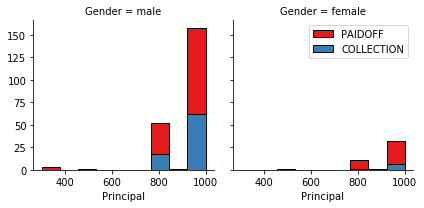

In [9]:
import seaborn as sns

bins = np.linspace(df.Principal.min(), df.Principal.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'Principal', bins=bins, ec="k")

g.axes[-1].legend()
plt.show()

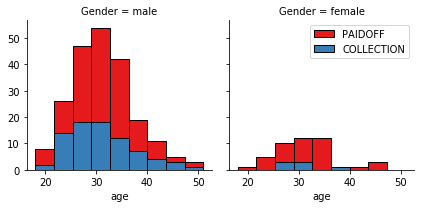

In [10]:
bins = np.linspace(df.age.min(), df.age.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'age', bins=bins, ec="k")

g.axes[-1].legend()
plt.show()

# Pre-processing:  Feature selection/extraction

### Lets look at the day of the week people get the loan 

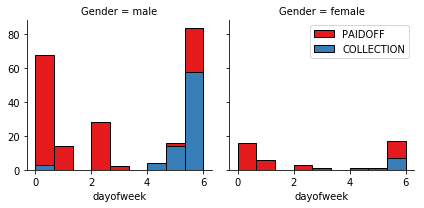

In [11]:
df['dayofweek'] = df['effective_date'].dt.dayofweek
bins = np.linspace(df.dayofweek.min(), df.dayofweek.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'dayofweek', bins=bins, ec="k")
g.axes[-1].legend()
plt.show()


We see that people who get the loan at the end of the week dont pay it off, so lets use Feature binarization to set a threshold values less then day 4 

In [12]:
df['weekend'] = df['dayofweek'].apply(lambda x: 1 if (x>3)  else 0)
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek,weekend
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,male,3,0
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,female,3,0
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,male,3,0
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,female,4,1
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,male,4,1


## Convert Categorical features to numerical values

Lets look at gender:

In [13]:
df.groupby(['Gender'])['loan_status'].value_counts(normalize=True)

Gender  loan_status
female  PAIDOFF        0.865385
        COLLECTION     0.134615
male    PAIDOFF        0.731293
        COLLECTION     0.268707
Name: loan_status, dtype: float64

86 % of female pay there loans while only 73 % of males pay there loan


Lets convert male to 0 and female to 1:


In [14]:
df['Gender'].replace(to_replace=['male','female'], value=[0,1],inplace=True)
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek,weekend
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,0,3,0
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,1,3,0
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,0,3,0
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,1,4,1
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,0,4,1


## One Hot Encoding  
#### How about education?

In [15]:
df.groupby(['education'])['loan_status'].value_counts(normalize=True)

education             loan_status
Bechalor              PAIDOFF        0.750000
                      COLLECTION     0.250000
High School or Below  PAIDOFF        0.741722
                      COLLECTION     0.258278
Master or Above       COLLECTION     0.500000
                      PAIDOFF        0.500000
college               PAIDOFF        0.765101
                      COLLECTION     0.234899
Name: loan_status, dtype: float64

#### Feature befor One Hot Encoding

In [16]:
df[['Principal','terms','age','Gender','education']].head()

,Principal,terms,age,Gender,education
0,1000,30,45,0,High School or Below
1,1000,30,33,1,Bechalor
2,1000,15,27,0,college
3,1000,30,28,1,college
4,1000,30,29,0,college


#### Use one hot encoding technique to conver categorical varables to binary variables and append them to the feature Data Frame 

In [17]:
Feature = df[['Principal','terms','age','Gender','weekend']]
Feature = pd.concat([Feature,pd.get_dummies(df['education'])], axis=1)
Feature.drop(['Master or Above'], axis = 1,inplace=True)
Feature.head()


,Principal,terms,age,Gender,weekend,Bechalor,High School or Below,college
0,1000,30,45,0,0,0,1,0
1,1000,30,33,1,0,1,0,0
2,1000,15,27,0,0,0,0,1
3,1000,30,28,1,1,0,0,1
4,1000,30,29,0,1,0,0,1


### Feature selection

Lets defind feature sets, X:

In [18]:
X = Feature
X[0:5]

,Principal,terms,age,Gender,weekend,Bechalor,High School or Below,college
0,1000,30,45,0,0,0,1,0
1,1000,30,33,1,0,1,0,0
2,1000,15,27,0,0,0,0,1
3,1000,30,28,1,1,0,0,1
4,1000,30,29,0,1,0,0,1


What are our lables?

In [32]:
y = df['loan_status'].apply(lambda loan_status: 0 if loan_status == 'PAIDOFF' else 1)
y[0:5]

0    0
1    0
2    0
3    0
4    0
Name: loan_status, dtype: int64

## Normalize Data 

Data Standardization give data zero mean and unit variance (technically should be done after train test split )

In [33]:
X= preprocessing.StandardScaler().fit(X).transform(X)
X[0:5]

array([[ 0.51578458,  0.92071769,  2.33152555, -0.42056004, -1.20577805,
        -0.38170062,  1.13639374, -0.86968108],
       [ 0.51578458,  0.92071769,  0.34170148,  2.37778177, -1.20577805,
         2.61985426, -0.87997669, -0.86968108],
       [ 0.51578458, -0.95911111, -0.65321055, -0.42056004, -1.20577805,
        -0.38170062, -0.87997669,  1.14984679],
       [ 0.51578458,  0.92071769, -0.48739188,  2.37778177,  0.82934003,
        -0.38170062, -0.87997669,  1.14984679],
       [ 0.51578458,  0.92071769, -0.3215732 , -0.42056004,  0.82934003,
        -0.38170062, -0.87997669,  1.14984679]])

# Classification 

Now, it is your turn, use the training set to build an accurate model. Then use the test set to report the accuracy of the model
You should use the following algorithm:
- K Nearest Neighbor(KNN)
- Decision Tree
- Support Vector Machine
- Logistic Regression



__ Notice:__ 
- You can go above and change the pre-processing, feature selection, feature-extraction, and so on, to make a better model.
- You should use either scikit-learn, Scipy or Numpy libraries for developing the classification algorithms.
- You should include the code of the algorithm in the following cells.

# K Nearest Neighbor(KNN)
Notice: You should find the best k to build the model with the best accuracy.  
**warning:** You should not use the __loan_test.csv__ for finding the best k, however, you can split your train_loan.csv into train and test to find the best __k__.

In [34]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.2, random_state=4)
print ('Train set:', X_train.shape,  y_train.shape)
print ('Test set:', X_test.shape,  y_test.shape)

Train set: (276, 8) (276,)
Test set: (70, 8) (70,)


In [35]:
y_test

63     0
34     0
186    0
146    0
130    0
178    0
334    1
14     0
166    0
101    0
345    1
325    1
128    0
134    0
83     0
173    0
100    0
169    0
6      0
254    0
112    0
24     0
332    1
70     0
11     0
66     0
47     0
72     0
91     0
220    0
      ..
18     0
200    0
290    1
308    1
204    0
55     0
68     0
82     0
84     0
88     0
1      0
12     0
195    0
92     0
216    0
223    0
177    0
285    1
323    1
202    0
293    1
248    0
61     0
45     0
182    0
287    1
253    0
33     0
320    1
154    0
Name: loan_status, Length: 70, dtype: int64

In [113]:
Ks = 10
mean_acc = np.zeros((Ks-1))
std_acc = np.zeros((Ks-1))
ConfustionMx = [];
for n in range(1,Ks):
    
    #Train Model and Predict  
    neigh = KNeighborsClassifier(n_neighbors = n).fit(X_train,y_train)
    yhat=neigh.predict(X_test)
    mean_acc[n-1] = metrics.accuracy_score(y_test, yhat)

    
    std_acc[n-1]=np.std(yhat==y_test)/np.sqrt(yhat.shape[0])

mean_acc

array([0.67142857, 0.77142857, 0.71428571, 0.77142857, 0.75714286,
       0.78571429, 0.78571429, 0.77142857, 0.77142857])

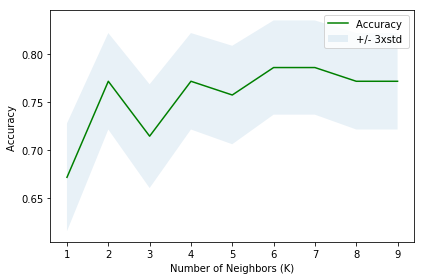

The best accuracy was with 0.7857142857142857 with k= 6


In [114]:
plt.plot(range(1,Ks),mean_acc,'g')
plt.fill_between(range(1,Ks),mean_acc - 1 * std_acc,mean_acc + 1 * std_acc, alpha=0.10)
plt.legend(('Accuracy ', '+/- 3xstd'))
plt.ylabel('Accuracy ')
plt.xlabel('Number of Neighbors (K)')
plt.tight_layout()
plt.show()
print( "The best accuracy was with", mean_acc.max(), "with k=", mean_acc.argmax()+1) 
neigh = KNeighborsClassifier(n_neighbors=mean_acc.argmax()+1).fit(X_train, y_train)


In [38]:
from sklearn.metrics import jaccard_similarity_score
from sklearn.metrics import f1_score
from sklearn.metrics import log_loss
print("Jaccard score: ", jaccard_similarity_score(y_test,yhat))
print("Logloss score: ", log_loss(y_test,neigh.predict_proba(X_test)))
print("F1 score: ", f1_score(y_test,yhat))

Jaccard score:  0.7714285714285715
Logloss score:  0.4711057462679464
F1 score:  0.42857142857142855


# Decision Tree

In [50]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
X_trainset, X_testset, y_trainset, y_testset = train_test_split(X, y, test_size=0.3, random_state=3)
print ('Train set:', X_trainset.shape,  y_trainset.shape)
print ('Test set:', X_testset.shape,  y_testset.shape)

Train set: (242, 8) (242,)
Test set: (104, 8) (104,)


In [60]:
#create instance of DecisionTreeClassifier called loan_status
loan_status = DecisionTreeClassifier(criterion="entropy", max_depth = 6)
loan_status

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=6,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [61]:
# fit the data with the training feature matrix X_trainset and training response vector y_trainset
loan_status.fit(X_trainset,y_trainset)

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=6,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [62]:
#Make some predictions on the testing dataset and store it into a variable called loanTree
loanTree = loan_status.predict(X_testset)

In [63]:
#Check the accuracy of the model
from sklearn import metrics
import matplotlib.pyplot as plt
print("DecisionTree Accuracy: ", metrics.accuracy_score(y_testset, loanTree))

DecisionTree Accuracy:  0.7019230769230769


In [67]:
from sklearn.metrics import jaccard_similarity_score
from sklearn.metrics import log_loss
print("Jaccard score: ", jaccard_similarity_score(y_testset,loanTree))
print("F1 score: ", f1_score(y_testset,loanTree))

Jaccard score:  0.7019230769230769
F1 score:  0.4150943396226415


# Support Vector Machine

In [68]:
import pandas as pd
import pylab as pl
import numpy as np
import scipy.optimize as opt
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
%matplotlib inline 
import matplotlib.pyplot as plt

In [69]:
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.2, random_state=4)
print ('Train set:', X_train.shape,  y_train.shape)
print ('Test set:', X_test.shape,  y_test.shape)

Train set: (276, 8) (276,)
Test set: (70, 8) (70,)


In [70]:
from sklearn import svm
clf = svm.SVC(kernel='rbf')
clf.fit(X_train, y_train) 

/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='rbf', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False)

In [71]:
yhat = clf.predict(X_test)
yhat [0:5]

array([1, 0, 0, 0, 0])

In [72]:
#F1 score for accuracy
from sklearn.metrics import f1_score
f1_score(y_test, yhat, average='weighted') 


0.7275882012724117

In [73]:
#jaccard index for accuracy
from sklearn.metrics import jaccard_similarity_score
jaccard_similarity_score(y_test, yhat)

0.7428571428571429

# Logistic Regression

In [74]:
import pandas as pd
import pylab as pl
import numpy as np
import scipy.optimize as opt
from sklearn import preprocessing
%matplotlib inline 
import matplotlib.pyplot as plt
#Train/Test Dataset
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.2, random_state=4)
print ('Train set:', X_train.shape,  y_train.shape)
print ('Test set:', X_test.shape,  y_test.shape)

Train set: (276, 8) (276,)
Test set: (70, 8) (70,)


In [75]:
#Build out model using LogisticRegression from sci-kit learn package
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
LR = LogisticRegression(C=0.01, solver='liblinear').fit(X_train,y_train)
LR

LogisticRegression(C=0.01, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='liblinear',
          tol=0.0001, verbose=0, warm_start=False)

In [76]:
#Predict test set
yhat = LR.predict(X_test)
yhat

array([1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0,
       1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 0])

In [77]:
#Evaluate model accuracy with jaccard index
from sklearn.metrics import jaccard_similarity_score
jaccard_similarity_score(y_test, yhat)

0.6857142857142857

# Model Evaluation using Test set

In [78]:
from sklearn import metrics
from sklearn.metrics import f1_score
from sklearn.metrics import log_loss

First, download and load the test set:

In [79]:
!wget -O loan_test.csv https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_test.csv

--2019-11-24 20:04:21--  https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_test.csv
Resolving s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)... 67.228.254.196
Connecting to s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)|67.228.254.196|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3642 (3.6K) [text/csv]
Saving to: ‘loan_test.csv’

100%[======================================>] 3,642       --.-K/s   in 0s      

2019-11-24 20:04:21 (375 MB/s) - ‘loan_test.csv’ saved [3642/3642]



### Load Test set for evaluation 

In [80]:
test_df = pd.read_csv('loan_test.csv')
test_df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,1,1,PAIDOFF,1000,30,9/8/2016,10/7/2016,50,Bechalor,female
1,5,5,PAIDOFF,300,7,9/9/2016,9/15/2016,35,Master or Above,male
2,21,21,PAIDOFF,1000,30,9/10/2016,10/9/2016,43,High School or Below,female
3,24,24,PAIDOFF,1000,30,9/10/2016,10/9/2016,26,college,male
4,35,35,PAIDOFF,800,15,9/11/2016,9/25/2016,29,Bechalor,male


In [81]:
#Convert Date Time for Dates in Dataset
test_df['due_date'] = pd.to_datetime(test_df['due_date'])
test_df['effective_date'] = pd.to_datetime(test_df['effective_date'])
test_df['dayofweek'] = test_df['effective_date'].dt.dayofweek
#Evaluate weekend field to see if people at the end of the week pay off the loan
test_df['weekend'] = test_df['dayofweek'].apply(lambda x: 1 if (x>3)  else 0)
#Assign numerical value to gender field
test_df['Gender'].replace(to_replace=['male','female'], value=[0,1],inplace=True)
#Assign numerical value to education field
Feature_test = test_df[['Principal','terms','age','Gender','weekend']]
Feature_test = pd.concat([Feature_test,pd.get_dummies(test_df['education'])], axis=1)
Feature_test.drop(['Master or Above'], axis = 1,inplace=True)
Feature_test.head()


,Principal,terms,age,Gender,weekend,Bechalor,High School or Below,college
0,1000,30,50,1,0,1,0,0
1,300,7,35,0,1,0,0,0
2,1000,30,43,1,1,0,1,0
3,1000,30,26,0,1,0,0,1
4,800,15,29,0,1,1,0,0


In [82]:
# Assign numerical value to loan status column
test_X = Feature_test
test_y = test_df['loan_status'].apply(lambda loan_status: 0 if loan_status == 'PAIDOFF' else 1)
print(test_y)



0     0
1     0
2     0
3     0
4     0
5     0
6     0
7     0
8     0
9     0
10    0
11    0
12    0
13    0
14    0
15    0
16    0
17    0
18    0
19    0
20    0
21    0
22    0
23    0
24    0
25    0
26    0
27    0
28    0
29    0
30    0
31    0
32    0
33    0
34    0
35    0
36    0
37    0
38    0
39    0
40    1
41    1
42    1
43    1
44    1
45    1
46    1
47    1
48    1
49    1
50    1
51    1
52    1
53    1
Name: loan_status, dtype: int64


In [83]:
#Optimal number of clusters from KNN clustering test
from sklearn import metrics
from sklearn.neighbors import KNeighborsClassifier
final_neigh = KNeighborsClassifier(n_neighbors = 7).fit(X,y)
yhat_knn = final_neigh.predict(test_X)
print(yhat_knn)



[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


In [84]:
#Standardize x values
test_X= preprocessing.StandardScaler().fit(test_X).transform(test_X)
test_X[0:5]

/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype uint8, int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/opt/conda/envs/Python36/lib/python3.6/site-packages/ipykernel/__main__.py:1: DataConversionWarning: Data with input dtype uint8, int64 were all converted to float64 by StandardScaler.
  if __name__ == '__main__':


array([[ 0.49362588,  0.92844966,  3.05981865,  1.97714211, -1.30384048,
         2.39791576, -0.79772404, -0.86135677],
       [-3.56269116, -1.70427745,  0.53336288, -0.50578054,  0.76696499,
        -0.41702883, -0.79772404, -0.86135677],
       [ 0.49362588,  0.92844966,  1.88080596,  1.97714211,  0.76696499,
        -0.41702883,  1.25356634, -0.86135677],
       [ 0.49362588,  0.92844966, -0.98251057, -0.50578054,  0.76696499,
        -0.41702883, -0.79772404,  1.16095912],
       [-0.66532184, -0.78854628, -0.47721942, -0.50578054,  0.76696499,
         2.39791576, -0.79772404, -0.86135677]])

In [104]:
#Show difference between accuracy scores for training set and test set for KNN clustering model
from sklearn import metrics
from sklearn.neighbors import KNeighborsClassifier
final_neigh = KNeighborsClassifier(n_neighbors = 6).fit(X,y)
yhat_knn = final_neigh.predict(test_X)
print("Train set Accuracy: ", metrics.accuracy_score(y, final_neigh.predict(X)))
print("Test set Accuracy: ", metrics.accuracy_score(test_y, yhat_knn))

Train set Accuracy:  0.8005780346820809
Test set Accuracy:  0.7592592592592593


In [105]:
#Summarize scores for KNN clustering model on test set
knn_jaccard = jaccard_similarity_score(test_y,yhat_knn)
knn_log_loss = log_loss(test_y,final_neigh.predict_proba(test_X))
knn_f1 = f1_score(test_y,yhat_knn,average='weighted')
print("KNN Jaccard score: ", knn_jaccard)
print("KNN Logloss score: ", knn_log_loss)
print("KNN F1 score: ", knn_f1)

KNN Jaccard score:  0.7592592592592593
KNN Logloss score:  1.1255244887311147
KNN F1 score:  0.7144140000438048


In [106]:
#Show difference between accuracy scores for training set and test set for Decision Tree model
from sklearn.tree import DecisionTreeClassifier
loan_status = DecisionTreeClassifier(criterion="entropy", max_depth = 6)
loan_status.fit(X_trainset,y_trainset)
final_yhat_tree = loan_status.predict(test_X)
print("Train set Accuracy: ", metrics.accuracy_score(y, loan_status.predict(X)))
print("Test set Accuracy: ", metrics.accuracy_score(test_y, final_yhat_tree))

Train set Accuracy:  0.7861271676300579
Test set Accuracy:  0.7962962962962963


In [107]:
#Summarize scores for decision tree model on test set
decision_tree_jaccard = jaccard_similarity_score(test_y,final_yhat_tree)
decision_tree_log_loss = log_loss(test_y,loan_status.predict_proba(test_X))
decision_tree_f1 = f1_score(test_y,final_yhat_tree,average='weighted')
print("Decision Tree Jaccard score: ", tree_jaccard)
print("Decision Tree Logloss score: ", tree_log_loss)
print("Decision Tree F1 score: ", tree_f1)

Decision Tree Jaccard score:  0.7962962962962963
Decision Tree Logloss score:  2.205652458113727
Decision Tree F1 score:  0.7937814357567445


In [108]:
#Show difference between accuracy scores for training set and test set for Support Vector Machine model
from sklearn import svm
clf = svm.SVC(kernel='rbf', probability=True)
clf.fit(X, y)
final_yhat_svm = clf.predict(test_X)
print("Train set Accuracy: ", metrics.accuracy_score(y, clf.predict(X)))
print("Test set Accuracy: ", metrics.accuracy_score(test_y, final_yhat_svm))

Train set Accuracy:  0.7601156069364162
Test set Accuracy:  0.7222222222222222


In [109]:
#Summarize scores for support vector machine model on test set
svm_jaccard = jaccard_similarity_score(test_y,final_yhat_svm)
svm_log_loss = log_loss(test_y,clf.predict_proba(test_X))
svm_f1 = f1_score(test_y,final_yhat_svm,average='weighted')
print("SVM Jaccard score: ", svm_jaccard)
print("SVM Logloss score: ", svm_log_loss)
print("SVM F1 score: ", svm_f1)

SVM Jaccard score:  0.7222222222222222
SVM Logloss score:  0.5541074834064618
SVM F1 score:  0.6212664277180406


In [110]:
#Show difference between accuracy scores for training set and test set for Logistic Regression model
from sklearn.linear_model import LogisticRegression
LR = LogisticRegression(C=0.01, solver='liblinear').fit(X,y)
final_yhat_lr = LR.predict(test_X)
print("Train set Accuracy: ", metrics.accuracy_score(y, LR.predict(X)))
print("Test set Accuracy: ", metrics.accuracy_score(test_y, final_yhat_lr))

Train set Accuracy:  0.7485549132947977
Test set Accuracy:  0.7407407407407407


In [111]:
#Summarize scores for Logistic Regression model on test set
lr_jaccard = jaccard_similarity_score(test_y,final_yhat_lr)
lr_log_loss = log_loss(test_y,LR.predict_proba(test_X))
lr_f1_score = f1_score(test_y,final_yhat_lr,average='weighted')
print("LR Jaccard score: ", lr_jaccard)
print("LR Logloss score: ", lr_log_loss)
print("LR F1 score: ", lr_f1_score)

LR Jaccard score:  0.7407407407407407
LR Logloss score:  0.5566084946309207
LR F1 score:  0.6304176516942475


/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [115]:
#Produce final report to report the accuracy of the built in model using different evaluation metrics
final_table = [["K_Nearest_Neighbor",knn_jaccard,knn_f1,'NA'],["Decision Tree",decision_tree_jaccard,decision_tree_f1,'NA'],
["Support_Vector_Machine",svm_jaccard,svm_f1,'NA'],["LogisticRegression",lr_jaccard,lr_f1_score,lr_log_loss]]

from tabulate import tabulate
from IPython.display import HTML
HTML(tabulate(final_table, headers= ['Algorithm', 'Jaccard', 'F1-score','LogLoss'], tablefmt='html'))


Algorithm,Jaccard,F1-score,LogLoss
K_Nearest_Neighbor,0.759259,0.714414,NA
Decision Tree,0.796296,0.793781,NA
Support_Vector_Machine,0.722222,0.621266,NA
LogisticRegression,0.740741,0.630418,0.5566084946309207


# Report
You should be able to report the accuracy of the built model using different evaluation metrics:

| Algorithm          | Jaccard | F1-score | LogLoss |
|--------------------|---------|----------|---------|
| KNN                | ?       | ?        | NA      |
| Decision Tree      | ?       | ?        | NA      |
| SVM                | ?       | ?        | NA      |
| LogisticRegression | ?       | ?        | ?       |

<h2>Want to learn more?</h2>

IBM SPSS Modeler is a comprehensive analytics platform that has many machine learning algorithms. It has been designed to bring predictive intelligence to decisions made by individuals, by groups, by systems – by your enterprise as a whole. A free trial is available through this course, available here: <a href="http://cocl.us/ML0101EN-SPSSModeler">SPSS Modeler</a>

Also, you can use Watson Studio to run these notebooks faster with bigger datasets. Watson Studio is IBM's leading cloud solution for data scientists, built by data scientists. With Jupyter notebooks, RStudio, Apache Spark and popular libraries pre-packaged in the cloud, Watson Studio enables data scientists to collaborate on their projects without having to install anything. Join the fast-growing community of Watson Studio users today with a free account at <a href="https://cocl.us/ML0101EN_DSX">Watson Studio</a>

<h3>Thanks for completing this lesson!</h3>

<h4>Author:  <a href="https://ca.linkedin.com/in/saeedaghabozorgi">Saeed Aghabozorgi</a></h4>
<p><a href="https://ca.linkedin.com/in/saeedaghabozorgi">Saeed Aghabozorgi</a>, PhD is a Data Scientist in IBM with a track record of developing enterprise level applications that substantially increases clients’ ability to turn data into actionable knowledge. He is a researcher in data mining field and expert in developing advanced analytic methods like machine learning and statistical modelling on large datasets.</p>

<hr>

<p>Copyright &copy; 2018 <a href="https://cocl.us/DX0108EN_CC">Cognitive Class</a>. This notebook and its source code are released under the terms of the <a href="https://bigdatauniversity.com/mit-license/">MIT License</a>.</p>